In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import numpy as np
from IPython.display import display

In [3]:
from extract import locm


path = '../experiments'
baseline_files = glob.glob(path + "/baseline/*.csv")
polocm_files = glob.glob(path+ "/polocm/*.csv" )

bl_dfs = [pd.read_csv(f) for f in baseline_files]
pl_dfs = [pd.read_csv(f) for f in polocm_files]

bl_df = pd.concat(bl_dfs, ignore_index=True)
pl_df = pd.concat(pl_dfs, ignore_index=True)


bl_df['scaled_dod'] = bl_df['actual_dod'] * 1000
pl_df['scaled_dod'] = pl_df['actual_dod'] * 1000


bl_success_df = bl_df[bl_df['result'] == 'Success']
pl_success_df = pl_df[pl_df['result'] == 'Success']

locm_df = pl_df[pl_df['dod'] == 0]
locm_success_df = pl_success_df[pl_success_df['dod'] == 0]
polocm_df = pl_df[pl_df['dod']>0]
polocm_success_df = pl_success_df[pl_success_df['dod'] >0]

polocm_success_df = polocm_success_df.merge(locm_success_df[['lo_id', 'executability']], on='lo_id', suffixes=('', '_locm'))
polocm_success_df['exe_diff'] = polocm_success_df['executability_locm'] - polocm_success_df['executability']

# Calculate the mean executability for LOCM2 for each domain
locm_exe_means = locm_success_df.groupby("domain")["executability"].mean()
polocm_success_df = polocm_success_df.merge(locm_exe_means, on='domain', suffixes=('', '_locm_means'))



In [4]:
# Filter for successful runs within the 600s limit
within_limit_df = polocm_df[(polocm_df['result'] == 'Success') ]

# Group by domain and dod, and count the total and successful instances
total_instances = polocm_df.groupby(['domain', 'dod']).size().reset_index(name='total_count')
success_instances = within_limit_df.groupby(['domain', 'dod']).size().reset_index(name='success_count')

# Merge the total and success counts
result_summary = total_instances.merge(success_instances, on=['domain', 'dod'], how='left')
result_summary['success_count'] = result_summary['success_count'].fillna(0)

# Calculate the success percentage
result_summary['success_percentage'] = (result_summary['success_count'] / result_summary['total_count']) * 100

# Pivot the table to get domains as columns and dod as rows
pivot_table = result_summary.pivot(index='dod', columns='domain', values='success_percentage').sort_index()

# Display the pivot table
print(pivot_table)

domain  blocksworld  childsnack       ferry  floortile     miconic     rovers  \
dod                                                                             
0.1      100.000000  100.000000  100.000000  82.758621  100.000000  68.965517   
0.2       86.206897  100.000000   79.310345  62.068966  100.000000  44.827586   
0.3       68.965517   41.379310   51.724138  44.827586   79.310345  31.034483   
0.4       58.620690   37.931034   51.724138  44.827586   58.620690  31.034483   
0.5       58.620690   27.586207   44.827586  27.586207   41.379310  13.793103   
0.6       52.631579   17.241379   41.379310  24.137931   31.034483  17.021277   
0.7       48.275862   13.793103   31.034483  17.241379   20.689655  10.344828   
0.8       44.827586    6.896552   27.586207  13.793103   24.137931  13.793103   
0.9       41.379310    3.448276   27.586207  10.344828   20.689655   6.896552   
1.0       27.586207    3.448276   20.689655  10.344828   20.689655   3.448276   

domain  satellite     sokob

/tmp/ipykernel_996384/3185216904.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  polocm_df['total_length_binned'] = pd.cut(polocm_df['total_length'], bins=bins, labels=bin_labels, right=True)
/tmp/ipykernel_996384/3185216904.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_instances_length = polocm_df.groupby('total_length_binned').size()
/tmp/ipykernel_996384/3185216904.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or 

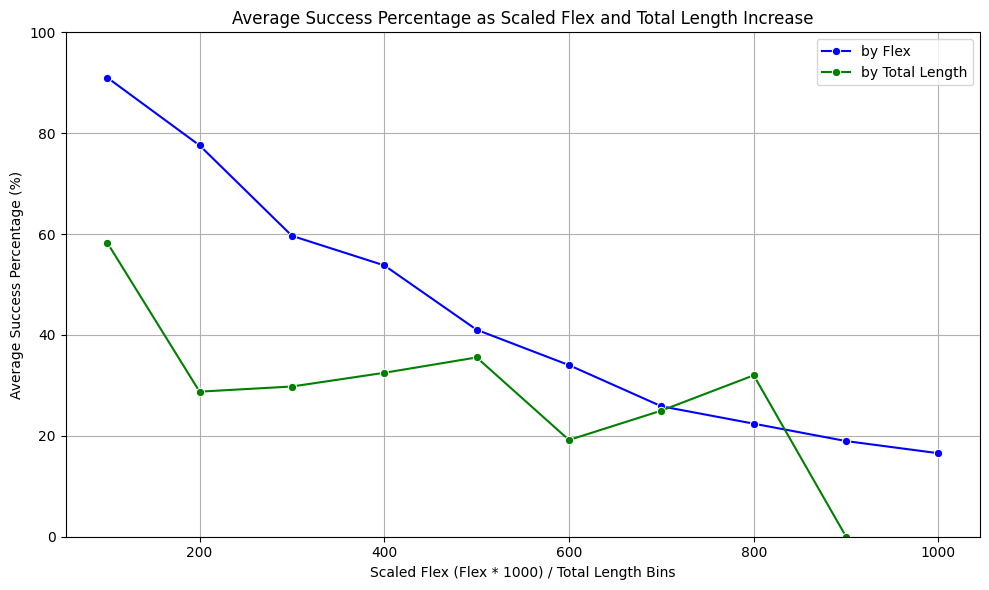

In [5]:
# Add a column for scaled_dod by multiplying each dod value by 1000
average_success_percentage = pivot_table.mean(axis=1).reset_index(name='average_success_percentage')
average_success_percentage['scaled_dod'] = average_success_percentage['dod'] * 1000


# Assuming `pivot_table` is defined and contains the success rate data for each dod and domain

# Add a column for scaled_dod by multiplying each dod value by 1000
average_success_percentage = pivot_table.mean(axis=1).reset_index(name='average_success_percentage')
average_success_percentage['scaled_dod'] = average_success_percentage['dod'] * 1000

# Calculate success rate for different total length bins
bins = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
bin_labels = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

# Assuming `polocm_df` is the original DataFrame with `total_length` and `result`
polocm_df['total_length_binned'] = pd.cut(polocm_df['total_length'], bins=bins, labels=bin_labels, right=True)
total_instances_length = polocm_df.groupby('total_length_binned').size()
success_instances_length = polocm_df[polocm_df['result'] == 'Success'].groupby('total_length_binned').size()

# Calculate success percentage per length bin
success_rate_length = (success_instances_length / total_instances_length * 100).reset_index(name='success_percentage')
success_rate_length['total_length_binned'] = success_rate_length['total_length_binned'].astype(int)

# Plotting
plt.figure(figsize=(10, 6))

# Plot average success percentage as scaled_dod increases
sns.lineplot(data=average_success_percentage, x='scaled_dod', y='average_success_percentage', marker='o', color='blue', label='by Flex')
# Plot success percentage as total length increases
sns.lineplot(data=success_rate_length, x='total_length_binned', y='success_percentage', marker='o', color='green', label='by Total Length')

# Customize labels and title
plt.xlabel("Scaled Flex (Flex * 1000) / Total Length Bins")
plt.ylabel("Average Success Percentage (%)")
plt.title("Average Success Percentage as Scaled Flex and Total Length Increase")
plt.ylim(0, 100)
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

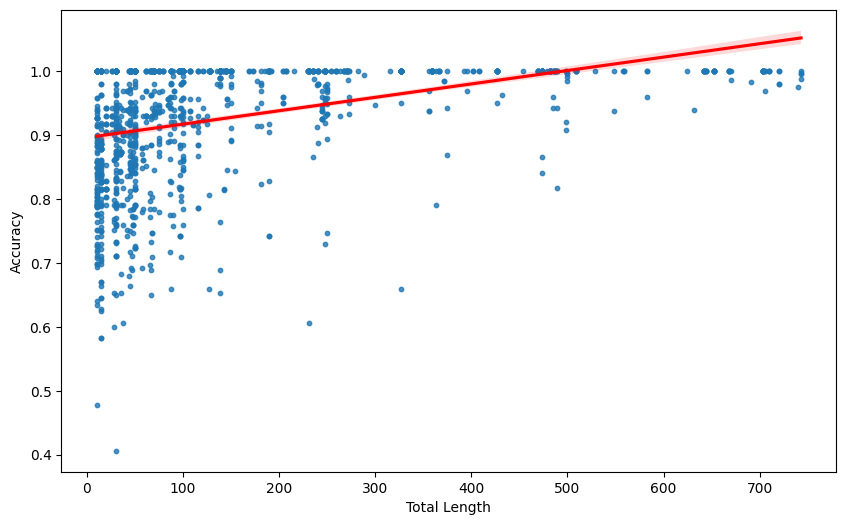

In [6]:

plt.figure(figsize=(10, 6))


# You can do the same for total_length
plt.figure(figsize=(10, 6))
sns.regplot(x='total_length', y='accuracy', data=polocm_success_df, scatter_kws={'s':10}, line_kws={'color':'red'})
plt.xlabel('Total Length')
plt.ylabel('Accuracy')
plt.show()



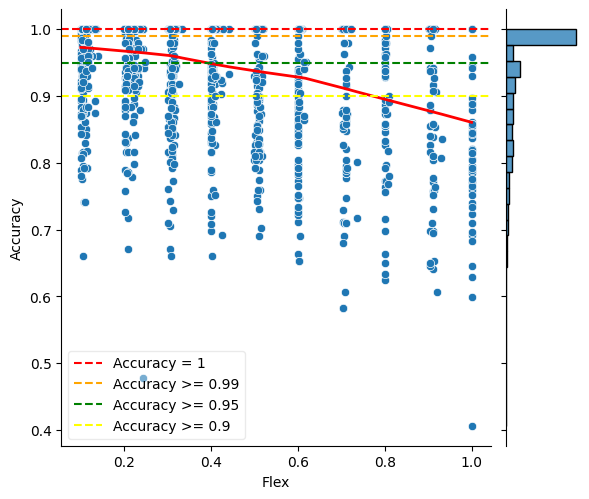

In [7]:

# Create the joint plot without the marginal x-axis bars
g = sns.jointplot(x='actual_dod', y='accuracy', data=polocm_success_df, kind='scatter', marginal_kws={'bins': 25, 'fill': True})

# Remove x-axis marginal plot
g.ax_marg_x.set_visible(False)

# Add regression line to show the trend
sns.regplot(x='actual_dod', y='accuracy', data=polocm_success_df, lowess=True, scatter=False, ax=g.ax_joint, color='red', line_kws={'lw': 2})
# 


# Add the horizontal lines back with accuracy thresholds
g.ax_joint.axhline(y=1, color='red', linestyle='--', label='Accuracy = 1')
g.ax_joint.axhline(y=0.99, color='orange', linestyle='--', label='Accuracy >= 0.99')
g.ax_joint.axhline(y=0.95, color='green', linestyle='--', label='Accuracy >= 0.95')
g.ax_joint.axhline(y=0.9, color='yellow', linestyle='--', label='Accuracy >= 0.9')

plt.xlabel('Flex')
plt.ylabel('Accuracy')
# Set the legend transparency (alpha)
legend = plt.legend(loc='lower left', framealpha=0.4)  # Adjust the transparency with framealpha
plt.show()


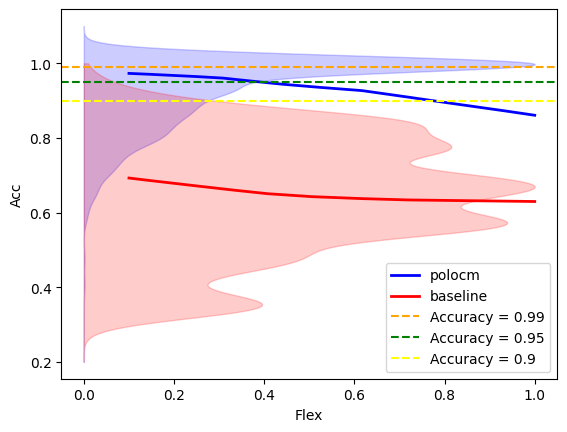

In [15]:
from scipy.stats import gaussian_kde



# 创建一个新的图形和轴
fig, ax = plt.subplots()


# 绘制 df1 的散点图和回归线
sns.regplot(x='actual_dod', y='accuracy', data=polocm_success_df, ax=ax, color='blue', label='polocm', lowess=True, scatter=False, line_kws={'lw': 2})


# 绘制 df2 的散点图和回归线
sns.regplot(x='actual_dod', y='accuracy', data=bl_success_df, ax=ax, color='red', label='baseline', lowess=True, scatter=False, line_kws={'lw': 2})


# 设置图例
ax.legend()


# 设置标题和轴标签
ax.set_xlabel('Flex')
ax.set_ylabel('Acc')

def normalize(arr, t_min, t_max):
    norm_arr = []
    diff = t_max - t_min
    diff_arr = max(arr) - min(arr)   
    for i in arr:
        temp = (((i - min(arr))*diff)/diff_arr) + t_min
        norm_arr.append(temp)
    return norm_arr

# 绘制 df1 的 acc 分布
kde1 = gaussian_kde(polocm_success_df['accuracy'])
x1 = np.linspace(0.2, 1.1, 1000)
y1 = kde1(x1)

# 归一化 y1 数据
y1_normalized = (y1 - np.min(y1)) / (np.max(y1) - np.min(y1))
# kde1 = sns.kdeplot(y=polocm_success_df['accuracy'], color='blue', fill=True, ax=ax, )
ax.fill_betweenx(x1, y1_normalized, color='blue', alpha=0.2, label='polocm')



# 绘制 df2 的 acc 分布
kde2 = gaussian_kde(bl_success_df['accuracy'])


# 调整 x 范围，例如从 0 到 10
x2 = np.linspace(0.2, 1, 1000)
y2 = kde2(x2)


# 归一化 y2 数据
y2_normalized = (y2 - np.min(y2)) / (np.max(y2) - np.min(y2))
ax.fill_betweenx(x2, y2_normalized, color='red', alpha=0.2, label='baseline')

#ax.hist(polocm_success_df['accuracy'], bins=25, edgecolor='black', alpha=0.3, label='polocm', orientation='horizontal',density=True)

#ax.hist(bl_success_df['accuracy'], bins=25, edgecolor='black', alpha=0.3, label='baseline', orientation='horizontal', density=True)

ax.axhline(y=0.99, color='orange', linestyle='--', label='Accuracy = 0.99')
ax.axhline(y=0.95, color='green', linestyle='--', label='Accuracy = 0.95')
ax.axhline(y=0.9, color='yellow', linestyle='--', label='Accuracy = 0.9')

def combine_legends(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = []
    unique_handles = []
    for handle, label in zip(handles, labels):
        if label not in unique_labels:
            unique_labels.append(label)
            unique_handles.append(handle)
    ax.legend(unique_handles, unique_labels)

combine_legends(ax)

# 显示图例


# 显示图形
plt.show()

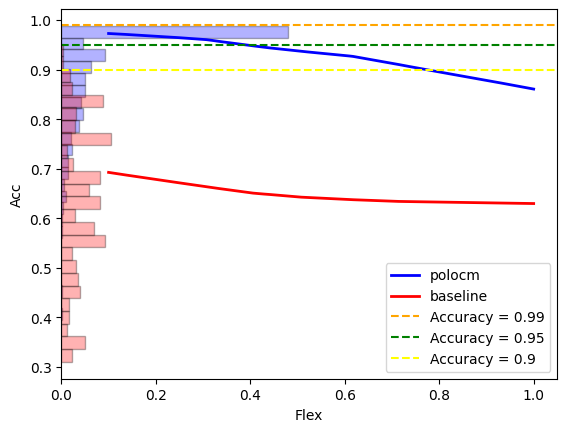

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# 创建一个新的图形和轴
fig, ax = plt.subplots()


# 绘制 df1 的散点图和回归线
sns.regplot(x='actual_dod', y='accuracy', data=polocm_success_df, ax=ax, color='blue', label='polocm', lowess=True, scatter=False, line_kws={'lw': 2})


# 绘制 df2 的散点图和回归线
sns.regplot(x='actual_dod', y='accuracy', data=bl_success_df, ax=ax, color='red', label='baseline', lowess=True, scatter=False, line_kws={'lw': 2})


# 设置图例
ax.legend()


# 设置标题和轴标签
ax.set_xlabel('Flex')
ax.set_ylabel('Acc')


# 绘制 df1 的 acc 分布
hist1, bins1 = np.histogram(polocm_success_df['accuracy'], bins=25, density=True)
bin_width1 = bins1[1] - bins1[0]
ax.barh(bins1[:-1], hist1 * bin_width1, height=bin_width1, edgecolor='black', alpha=0.3, label='polocm', color='blue')


# 绘制 df2 的 acc 分布
hist2, bins2 = np.histogram(bl_success_df['accuracy'], bins=25, density=True)
bin_width2 = bins2[1] - bins2[0]
ax.barh(bins2[:-1], hist2 * bin_width2, height=bin_width2, edgecolor='black', alpha=0.3, label='baseline', color='red')


ax.axhline(y=0.99, color='orange', linestyle='--', label='Accuracy = 0.99')
ax.axhline(y=0.95, color='green', linestyle='--', label='Accuracy = 0.95')
ax.axhline(y=0.9, color='yellow', linestyle='--', label='Accuracy = 0.9')


def combine_legends(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = []
    unique_handles = []
    for handle, label in zip(handles, labels):
        if label not in unique_labels:
            unique_labels.append(label)
            unique_handles.append(handle)
    ax.legend(unique_handles, unique_labels)


combine_legends(ax)


# 显示图形
plt.show()

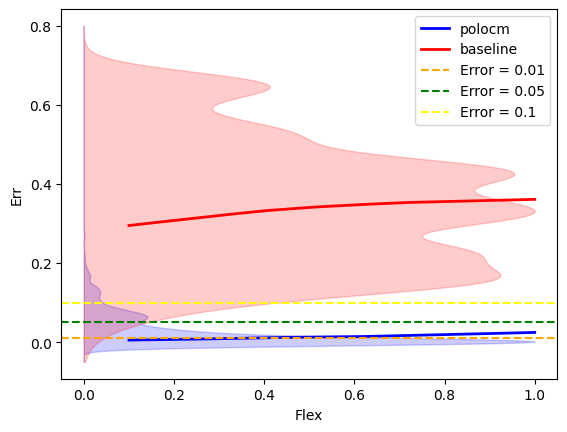

In [10]:
# 创建一个新的图形和轴
fig, ax = plt.subplots()


# 绘制 df1 的散点图和回归线
sns.regplot(x='actual_dod', y='error_rate', data=polocm_success_df,label='polocm', lowess=True, scatter=False, ax=ax, color='blue', line_kws={'lw': 2})


# 绘制 df2 的散点图和回归线
sns.regplot(x='actual_dod', y='error_rate', data=bl_success_df,label='baseline', lowess=True, scatter=False, ax=ax, color='red', line_kws={'lw': 2})


# 设置图例
ax.legend()


# 设置标题和轴标签
ax.set_xlabel('Flex')
ax.set_ylabel('Err')


# 绘制 df1 的 acc 分布
kde1 = gaussian_kde(polocm_success_df['error_rate'])
x1 = np.linspace(-0.05, 0.8, 1000)
y1 = kde1(x1)

# 归一化 y1 数据
y1_normalized = (y1 - np.min(y1)) / (np.max(y1) - np.min(y1))
ax.fill_betweenx(x1, y1_normalized, color='blue', alpha=0.2, label='polocm')



# 绘制 df2 的 acc 分布
kde2 = gaussian_kde(bl_success_df['error_rate'])


# 调整 x 范围，例如从 0 到 10
x2 = np.linspace(-0.05, 0.8, 1000)
y2 = kde2(x2)


# 归一化 y2 数据
y2_normalized = (y2 - np.min(y2)) / (np.max(y2) - np.min(y2))
ax.fill_betweenx(x2, y2_normalized, color='red', alpha=0.2, label='baseline')



ax.axhline(y=0.01, color='orange', linestyle='--', label='Error = 0.01')
ax.axhline(y=0.05, color='green', linestyle='--', label='Error = 0.05')
ax.axhline(y=0.1, color='yellow', linestyle='--', label='Error = 0.1')


combine_legends(ax)

# 显示图例


# 显示图形
plt.show()

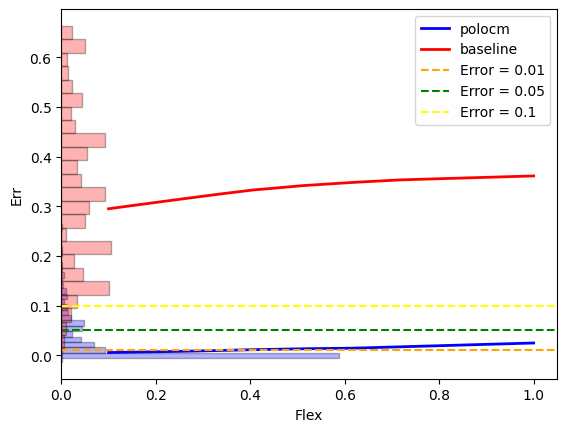

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# 创建一个新的图形和轴
fig, ax = plt.subplots()


# 绘制 df1 的散点图和回归线
sns.regplot(x='actual_dod', y='error_rate', data=polocm_success_df, label='polocm', lowess=True, scatter=False, ax=ax, color='blue', line_kws={'lw': 2})


# 绘制 df2 的散点图和回归线
sns.regplot(x='actual_dod', y='error_rate', data=bl_success_df, label='baseline', lowess=True, scatter=False, ax=ax, color='red', line_kws={'lw': 2})


# 设置图例
ax.legend()


# 设置标题和轴标签
ax.set_xlabel('Flex')
ax.set_ylabel('Err')


# 绘制 df1 的 error_rate 分布
hist1, bins1 = np.histogram(polocm_success_df['error_rate'], bins=25, density=True)
bin_width1 = bins1[1] - bins1[0]
ax.barh(bins1[:-1], hist1 * bin_width1, height=bin_width1, edgecolor='black', alpha=0.3, label='polocm', color='blue')


# 绘制 df2 的 error_rate 分布
hist2, bins2 = np.histogram(bl_success_df['error_rate'], bins=25, density=True)
bin_width2 = bins2[1] - bins2[0]
ax.barh(bins2[:-1], hist2 * bin_width2, height=bin_width2, edgecolor='black', alpha=0.3, label='baseline', color='red')


ax.axhline(y=0.01, color='orange', linestyle='--', label='Error = 0.01')
ax.axhline(y=0.05, color='green', linestyle='--', label='Error = 0.05')
ax.axhline(y=0.1, color='yellow', linestyle='--', label='Error = 0.1')


def combine_legends(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = []
    unique_handles = []
    for handle, label in zip(handles, labels):
        if label not in unique_labels:
            unique_labels.append(label)
            unique_handles.append(handle)
    ax.legend(unique_handles, unique_labels)


combine_legends(ax)


# 显示图形
plt.show()

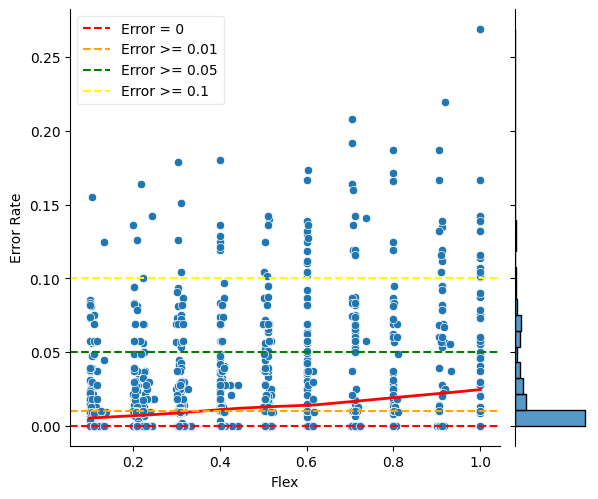

In [11]:
# Create the joint plot without the marginal x-axis bars
g = sns.jointplot(x='actual_dod', y='error_rate', data=polocm_success_df, kind='scatter', marginal_kws={'bins': 25, 'fill': True})

# Remove x-axis marginal plot
g.ax_marg_x.set_visible(False)

# Add regression line to show the trend
sns.regplot(x='actual_dod', y='error_rate', data=polocm_success_df, lowess=True, scatter=False, ax=g.ax_joint, color='red', line_kws={'lw': 2})

# Change the color of y-axis marginal bars to match the scatter and lines
# for bar in g.ax_marg_y.patches:
#     bar.set_facecolor('blue')

# Add the horizontal lines back with accuracy thresholds
g.ax_joint.axhline(y=0, color='red', linestyle='--', label='Error = 0')
g.ax_joint.axhline(y=0.01, color='orange', linestyle='--', label='Error >= 0.01')
g.ax_joint.axhline(y=0.05, color='green', linestyle='--', label='Error >= 0.05')
g.ax_joint.axhline(y=0.1, color='yellow', linestyle='--', label='Error >= 0.1')

plt.xlabel('Flex')
plt.ylabel('Error Rate')
# Set the legend transparency (alpha)
legend = plt.legend(loc='upper left', framealpha=0.4)  # Adjust the transparency with framealpha
plt.show()

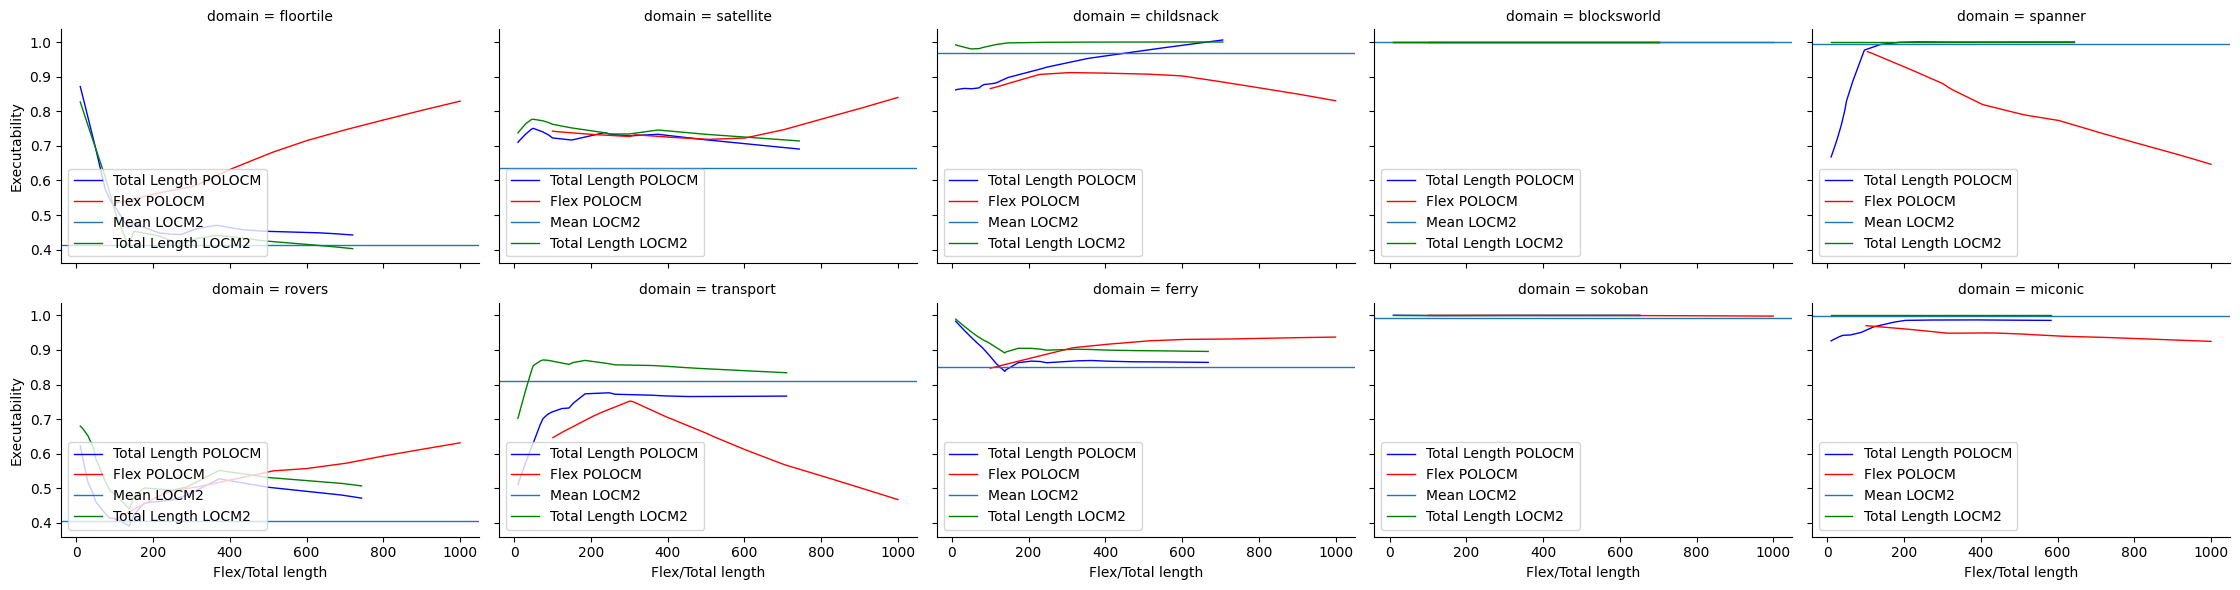

In [12]:


# Set up the facet grid to create a plot for each domain
g = sns.FacetGrid(polocm_success_df, col="domain", col_wrap=5, height=3, aspect=1.5)

g.map_dataframe(sns.regplot, x="total_length", y="executability", line_kws={'color':'blue', 'lw':1}, scatter=False, lowess=True)

# Second line for scaled_dod vs runtime with LOWESS smoothing
g.map_dataframe(sns.regplot, x="scaled_dod", y="executability", line_kws={'color':'red', 'lw':1}, scatter=False, lowess=True)

# # First line for total_length vs runtime with LOWESS smoothing
# g.map_dataframe(sns.regplot, x="total_length", y="executability", line_kws={'color':'blue', 'lw':1}, scatter=False, lowess=True)

# g.map_dataframe(sns.regplot, x="scaled_dod", y="executability_locm", line_kws={'color':'orange', 'lw':1}, scatter=False, lowess=True)



def add_horizontal_line(data, color='orange', **kwargs):
    mean_value = data["executability_locm_means"].iloc[0]  # Get the mean value for this domain
    plt.axhline(mean_value, color=color, linestyle='-', linewidth=1)

g.map_dataframe(add_horizontal_line)

g.map_dataframe(sns.regplot, x="total_length", y="executability_locm", line_kws={'color':'green', 'lw':1}, scatter=False, lowess=True)

# Customize the legend and labels
for ax in g.axes.flat:
    ax.legend(["Total Length POLOCM", "Flex POLOCM", "Mean LOCM2", "Total Length LOCM2"], loc="lower left")

g.set_axis_labels("Flex/Total length", "Executability")
# Adjust layout and show the plot
plt.tight_layout()
plt.show()
